<a href="https://colab.research.google.com/github/urieliram/statistical/blob/main/Tarea8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
import numpy as np
import pandas as pd
import itertools
import warnings
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV, LarsCV
from sklearn.metrics import (roc_curve, roc_auc_score, confusion_matrix, accuracy_score, f1_score, precision_recall_curve) 
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from scipy.stats import bernoulli
from scipy.stats import norm
import scipy.stats
import statsmodels.api as sm
import statsmodels.tools.eval_measures as bias
import seaborn as sns
import arviz as az
import pymc3 as pm
import theano.tensor as tt
from IPython.core.pylabtools import figsize
warnings.filterwarnings("ignore")

Leemos los datos para un ejemplo de dos variables

In [31]:
df = pd.read_csv('logreg1.csv')
df = df.assign(const=1)
print(df)
dfy = df['frac'] 
dfx = df[['const','sex','age']] ## Predictors
x   = pd.DataFrame(df[['sex','age']]).to_numpy()
y   = pd.DataFrame(df[['frac']]).to_numpy()
#Y   = pd.DataFrame(df[['Y']]).to_numpy()
n = dfx.shape[0]

    sex  age  frac  const
0     1   69     1      1
1     1   57     1      1
2     1   61     1      1
3     0   60     0      1
4     1   69     1      1
..  ...  ...   ...    ...
95    1   68     0      1
96    1   75     1      1
97    1   52     0      1
98    1   53     0      1
99    1   70     1      1

[100 rows x 4 columns]


queremos saber las distribuciones de probabilidad de los parámetros desconocidos del modelo.

Probar que tan buenos son unos parámetros. Cuanto mayor sea la probabilidad P(teta|x) de los valores de los parámetros dados los datos, más probable será que sean los parámetros "reales" de la distribución de la población.

Esto significa que podemos transformar nuestro problema de encontrar los parámetros de la distribución de la población, a encontrar los valores de los parámetros que maximizan el valor P(θ|x).

podemos transformar nuestro problema de encontrar los parámetros de la distribución de la población, a encontrar los valores de los parámetros que maximizan el valor P(θ|x).

[Bayesian logistic regression with PyMC3](https://towardsdatascience.com/bayesian-logistic-regression-with-pymc3-8e17c576f31a)

[Bayesian Linear Regression in Python via PyMC3](https://towardsdatascience.com/bayesian-linear-regression-in-python-via-pymc3-ab8c2c498211)

[PyMC3](https://docs.pymc.io/en/v3/api/distributions/discrete.html)

[Logistic regression with PyMC3](https://goldinlocks.github.io/Bayesian-logistic-regression-with-pymc3/)

[Bayesian Learning for Machine Learning: Part II - Linear Regression](https://wso2.com/blog/research/part-two-linear-regression/)

[An Introduction to Logistic Regression in Python](https://www.simplilearn.com/tutorials/machine-learning-tutorial/logistic-regression-in-python)

[Bayesian inference tutorial: a hello world example](https://datapythonista.me/blog/bayesian-inference-tutorial-a-hello-world-example.html)

[Ejemplo de Bayes con covid y síntomas](https://statsthinking21.github.io/statsthinking21-python/10-BayesianStatistics.html)

[Estimating Probabilities with Bayesian Modeling in Python](https://towardsdatascience.com/estimating-probabilities-with-bayesian-modeling-in-python-7144be007815)

[Estimando probabilidades con inferencia bayesiana](https://github.com/WillKoehrsen/probabilistic-programming/blob/master/Estimating%20Probabilities%20with%20Bayesian%20Inference.ipynb)

Bayesian Linear Regression in Python: Using Machine Learning to Predict Student Grades: [Parte 1](https://towardsdatascience.com/bayesian-linear-regression-in-python-using-machine-learning-to-predict-student-grades-part-1-7d0ad817fca5) y [Parte2](https://towardsdatascience.com/bayesian-linear-regression-in-python-using-machine-learning-to-predict-student-grades-part-2-b72059a8ac7e)

[Bayesian Inference in Python](https://towardsai.net/p/l/bayesian-inference-in-python) 

[Bayesian Statistics explained to Beginners in Simple English](Bayesian Statistics explained to Beginners in Simple English)

[Bayesian inference in Python-coursera](https://www.coursera.org/lecture/advanced-machine-learning-signal-processing/bayesian-inference-in-python-9D2Pz)

[A Guide to Bayesian Statistics in Python for Beginners](https://analyticsindiamag.com/a-guide-to-bayesian-statistics-in-python-for-beginners/)

[BBN: Bayesian Belief Networks — How to Build Them Effectively in Python](https://towardsdatascience.com/bbn-bayesian-belief-networks-how-to-build-them-effectively-in-python-6b7f93435bba)

[Bayesian multivariate linear regression Yni](https://en.wikipedia.org/wiki/Bayesian_multivariate_linear_regression#:~:text=In%20statistics%2C%20Bayesian%20multivariate%20linear,a%20single%20scalar%20random%20variable.)



# Ejemplo de regresión logistica bayesiana

In [33]:
df=pd.read_csv('datatest.txt')
#df['date']=pd.to_datetime(df['date'])
#df.sample(5)
#df.describe()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
count,2665.000000,2665.000000,2665.000000,2665.000000,2665.000000,2665.000000
mean,21.433876,25.353937,193.227556,717.906470,0.004027,0.364728
std,1.028024,2.436842,250.210906,292.681718,0.000611,0.481444
min,20.200000,22.100000,0.000000,427.500000,0.003303,0.000000
25%,20.650000,23.260000,0.000000,466.000000,0.003529,0.000000
50%,20.890000,25.000000,0.000000,580.500000,0.003815,0.000000
75%,22.356667,26.856667,442.500000,956.333333,0.004532,1.000000
max,24.408333,31.472500,1697.250000,1402.250000,0.005378,1.000000


In [34]:
lower=-10**6
higher=10**6
with pm.Model() as first_model:
    #priors on parameters
    beta_0=pm.Uniform('beta_0', lower=lower, upper= higher)
    beta_temp=pm.Uniform('beta_temp', lower, higher)
    beta_humid=pm.Uniform('beta_humid', lower, higher)
    beta_light=pm.Uniform('beta_light', lower, higher)
    beta_co2=pm.Uniform('beta_co2', lower, higher)
    beta_humid_ratio=pm.Uniform('beta_humid_ration', lower, higher)
    
    #the probability of belonging to class 1
    p = pm.Deterministic('p', pm.math.sigmoid(beta_0+beta_temp*df['Temperature']+
                               beta_humid*df['Humidity']+
                               beta_light*df['Light']+
                               beta_co2*df['CO2']+
                               beta_humid_ratio*df['HumidityRatio']))
with first_model:
    #fit the data 
    observed=pm.Bernoulli("occupancy", p, observed=df['Occupancy'])
    start=pm.find_MAP()
    step=pm.Metropolis()
    
    #samples from posterior distribution 
    trace=pm.sample(2500, step=step, start=start)
    burned_trace=trace[1500:]

Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [beta_humid_ration]
>Metropolis: [beta_co2]
>Metropolis: [beta_light]
>Metropolis: [beta_humid]
>Metropolis: [beta_temp]
>Metropolis: [beta_0]


Sampling 2 chains for 1_000 tune and 2_500 draw iterations (2_000 + 5_000 draws total) took 33 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


KeyboardInterrupt: ignored

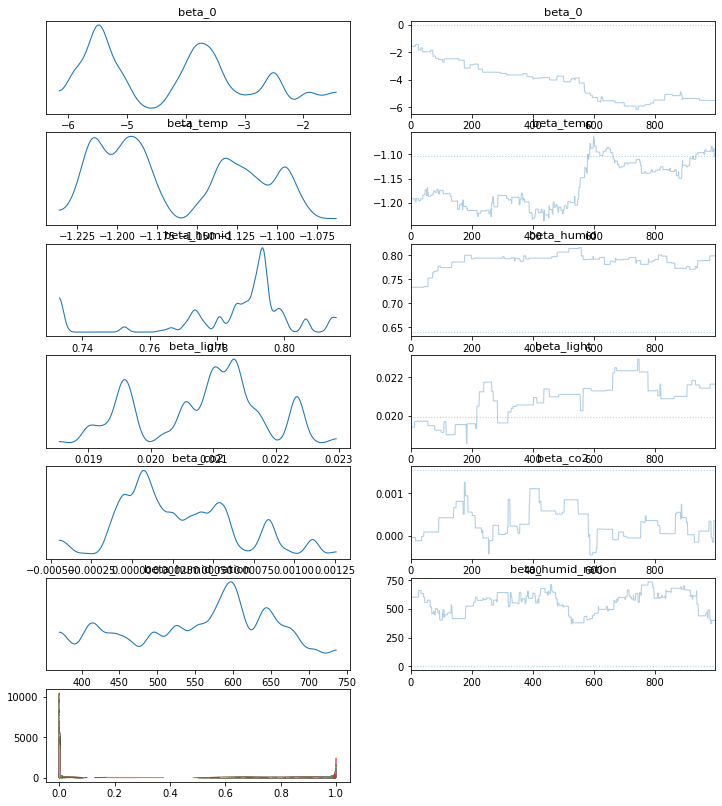

In [35]:
##Graficamos las distribuciones resultantes de nuestro primer modelo
pm.traceplot(burned_trace)
plt.show()

In [ ]:
## Ahora calculamos la media de nuestra primera versión de las muestras generadas por la simulación.
coeffs=['beta_0', 'beta_temp', 'beta_humid', 'beta_light', 'beta_co2', 'beta_humid_ration']
d=dict()
for item in coeffs:
    d[item]=[burned_trace[item].mean()]
    
result_coeffs=pd.DataFrame.from_dict(d)    
result_coeffs
#coeff_result=pd.DataFrame(d)    
#coeff_result

## Comparamos con la versión frecuentista de la regresión logística.

Ahora, comparamos los resultados con un análisis frecuentista de regresión logística de la librería **statsmodels**.

In [ ]:
model = sm.Logit(dfy, dfx)
results = model.fit()
print(results.summary())

In [ ]:
#https://github.com/nadheesh/bayesian-regression/blob/master/logistic_regression.py
import numpy as np
import pymc3 as pm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from theano import shared, tensor as tt

def invlogit(x):
    """
    sigmoid operator
    :param x: int/float or array like data-structure
    :return: sigmoid of x
    """
    if type(x) is np.ndarray:
        return np.exp(x) / (1 + np.exp(x))
    return tt.exp(x) / (1 + tt.exp(x))

size           = 100 # no of data samples
true_intercept = 0   # intercept of the regression line
true_slope1     = 1   # slop (coefficient) of x
true_slope2     = 1   # slop (coefficient) of x

x1 = np.linspace(0, 1, size)  # generate some random values for x in the given range (0,1)
x2 = np.linspace(0, 1, size)  # generate some random values for x in the given range (0,1)

# performs simple linear regression
# y = sigmoid(a + b*x)
true_regression_line = invlogit(true_intercept + true_slope1 * x1 + true_slope2 * x2)

# we can't use true regression values for training the model
# therefore, add some random noise
y = true_regression_line + np.random.normal(scale=0.3, size=size)

# assume this is a binary classifications
# convert y values to labels
true_regression_line = true_regression_line >= 0.5
y = y >= 0.5

# split the data points into train and test split
x_train, x_test, y_train, y_test, true_y1, true_y2 = train_test_split(x, y, true_regression_line)

# we use a shared variable from theano to feed the x values into the model
# this is need for PPC
# when using the model for predictions we can set this shared variable to x_test
shared_x = shared(x_train)

# training the model
# model specifications in PyMC3 are wrapped in a with-statement
with pm.Model() as model:

    # Define priors
    x_coeff   = pm.Normal('x', 0, sd=20)            # prior for coefficient of x
    intercept = pm.Normal('Intercept', 0, sd=20)  # prior for the intercept
    sigma     = pm.HalfCauchy('sigma', beta=10)       # prior for the error term of due to the noise

    reg = intercept + tt.dot(shared_x, x_coeff)
    p = pm.Deterministic("p", invlogit(reg))      # represent the logistic regression relationship

    # Define likelihood
    likelihood = pm.Bernoulli('y', p=p, observed=y_train)

    # Inference!
    trace = pm.sample(1000)  # draw 3000 posterior samples using NUTS sampling

# predicting the unseen y values
# uses posterior predictive checks (PPC)
shared_x.set_value(x_test)  # let's set the shared x to the test dataset
ppc = pm.sample_posterior_predictive(trace, model=model, samples=1000)  # performs PPC
predictions = ppc['y'].mean(axis=0)  # compute the mean of the samples draws from each new y

predictions = predictions >= 0.5
# now you can check the error
#print("Accuracy of logistic regression using bayesian : {0}".format(accuracy_score(y_test, predictions))) ##error

# plot the traceplot
pm.traceplot(trace)


In [32]:
p = np.zeros(n); frac = np.zeros(n); Likelihood = 1

alpha=0; b_sex=1; b_age=1; #inicial data
#for i in range(n):

    ## Linear regression on logit
    #model = sm.Logit(dfy, dfx)
    #p[i] = alpha + b_sex * dfx[i,1] + b_age * dfx[i,2] #<----------cambiar a logit
    ## Likelihood function for each data point
    #print(p[i])
    #frac[i]  = bernoulli(0.01, p)

    #exp_e = np.exp(alpha + b_sex * dfx[i,1] + b_age * dfx[i,2])
    #print(alpha,dfx[i,1],dfx[i,2])
    #print(exp_e)
    #print(Likelihood)
    #Likelihood = Likelihood * np.power(exp_e/(1+exp_e),dfy[i]) * np.power(1-(exp_e/(1+exp_e)),1-dfy[i])
    
#alpha = norm(0.0,1.0E-2) # Prior for intercept
#b_sex = norm.ppf([0.001, 0.5, 0.999])
#b_age = norm.ppf([0.001, 0.5, 0.999])